In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion


In [2]:
mnist = fetch_openml('mnist_784')
X, y = np.array(mnist['data'], dtype=float), np.array(mnist['target'], dtype=float)
print('fetched!')

fetched!


## Task 1

In [3]:
train_size = 60000
shuffle_index = np.random.permutation(train_size)
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [26]:
param_grid = [{'weights': ['uniform', 'distance'], 'n_neighbors': [2, 3, 4, 5]}]
kn_cls = KNeighborsClassifier()
grid_search = GridSearchCV(kn_cls, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print('competed!')

competed!


In [28]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)
print(grid_search.best_estimator_)

0.8170373308484747 {'n_neighbors': 2, 'weights': 'uniform'}
0.7333371212023385 {'n_neighbors': 2, 'weights': 'distance'}
0.7640462464188059 {'n_neighbors': 3, 'weights': 'uniform'}
0.7303880247284088 {'n_neighbors': 3, 'weights': 'distance'}
0.7676587783644502 {'n_neighbors': 4, 'weights': 'uniform'}
0.718656153293539 {'n_neighbors': 4, 'weights': 'distance'}
0.7641334961902927 {'n_neighbors': 5, 'weights': 'uniform'}
0.738342738841522 {'n_neighbors': 5, 'weights': 'distance'}
KNeighborsClassifier(n_neighbors=4, weights='distance')


In [26]:
def coincidence(predictions, targets):
    n_correct = np.sum(predictions == targets)
    return n_correct / len(targets)


try:
    best_cls = grid_search.best_estimator_
except:
    best_cls = KNeighborsClassifier(n_neighbors=4, weights='distance')
    best_cls.fit(X_train, y_train)
y_predict = best_cls.predict(X_test)

print(coincidence(y_predict, y_test))

0.9714


In [ ]:
## Task 2

In [22]:
def plot_digit(flat_digit, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(flat_digit.reshape(28, 28), cmap=mpl.cm.binary, interpolation='nearest')
    ax.axis('off')

class ImageShifter(BaseEstimator, TransformerMixin):
    def __init__(self, direction):
        self.direction = direction

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.array([
            self.__move_image(digit.reshape(28, 28)).ravel()
            for digit in X])

    def __move_image(self, image):
        if self.direction == 'up':
            zeros = np.zeros((1, image.shape[0]))
            return np.vstack([image[1:, :], zeros])
        elif self.direction == 'down':
            zeros = np.zeros((1, image.shape[0]))
            return np.vstack([zeros, image[:-1, :]])
        elif self.direction == 'left':
            zeros = np.zeros((image.shape[0], 1))
            return np.hstack([image[:, 1:], zeros])
        elif self.direction == 'right':
            zeros = np.zeros((image.shape[0], 1))
            return np.hstack([zeros, image[:, :-1]])

directions = ['up', 'down', 'left', 'right']
image_shifters = [ImageShifter(direction) for direction in directions]
# all_directions_extender = FeatureUnion(transformer_list=[
#     (direction + '_shift', ImageShifter(direction)) for direction in directions
# ])

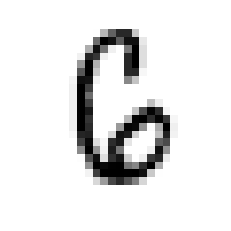

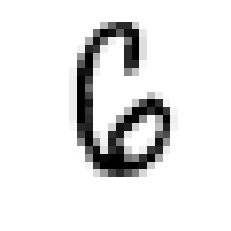

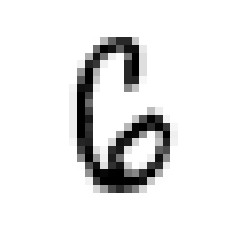

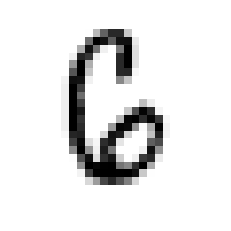

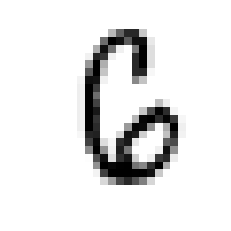

In [23]:
random_index = 1489
common_digit = X_train[random_index]
plot_digit(common_digit)

for shifter in image_shifters:
    plot_digit(shifter.transform([common_digit]))

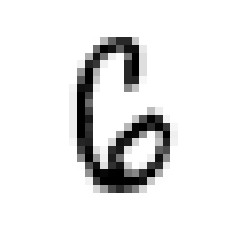

In [24]:
X_train_expanded = np.concatenate([X_train, *[shifter.transform(X_train) for shifter in image_shifters]])
y_train_expanded = np.tile(y_train, 5)
plot_digit(X_train_expanded[2 * len(X_train) + random_index].reshape(28, 28))

In [27]:
best_cls.fit(X_train_expanded, y_train_expanded)
y_predict = best_cls.predict(X_test)
print(coincidence(y_predict, y_test))

0.9763
